# Talos Example with moving foot

In [1]:
import sys
sys.path.append('lib')

import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time
from tf_robot_learning import kinematic as tk

from IPython.core import display

DATA_PATH = '/home/teguh/git/publications/learning_distribution_gan/tf_robot_learning/data'


%load_ext autoreload
%autoreload 2
%matplotlib inline

## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define robot

In [3]:
urdf = tk.urdf_from_file(DATA_PATH + '/urdf/talos_reduced.urdf');
display.clear_output()

#list of end-effector
tips = OrderedDict({
    'r_gripper'	: 'gripper_right_base_link',
    'l_gripper'	: 'gripper_left_base_link',
    'r_foot' 	: 'right_sole_link',
    'l_foot' 	: 'left_sole_link',
})

#define the robot as a kinematic chain, loaded from urdf
chain_names = ['r_gripper', 'l_gripper', 'r_foot', 'l_foot'] 
chain = tk.ChainDict({
    name: tk.kdl_chain_from_urdf_model(urdf, 'base_link', tip=tip)
    for name, tip in tips.items()
})

#define the default position and orientation of the end-effector
ee = OrderedDict({
        'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'l_foot': [-0.02,  0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
        'r_foot': [-0.02,  -0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
})

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Load data 

In [4]:
def param_to_joint_pos(x):
    """
    convert the config parameter x to full robot configurations: joint angles, base position and orientation
    """
    return x[..., :chain.nb_joint],\
        tf.concat([x[..., chain.nb_joint:chain.nb_joint+3]], -1),\
        tk.rotation.rpy(tf.zeros_like(x[..., -3:]))

In [5]:
def q_augmented(q):
    """ Define augmented data transformations: (joint_angles, right foot pose, and left foot pose)"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat([
            q,
            chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1],
            chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1]
        ], -1)

In [6]:
def q_target(q):
    """ Extract the target"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # orientation of each foot
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, :3] for name in chain_names]
            , -1)

In [7]:
def q_foot_ori(q):
    """ Extract the foot orientation """
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # position of each end-effector
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, 3:] for name in chain_names[2:]]
            , -1)

In [8]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]


In [9]:
q_eval = tf1.placeholder(tf.float32, (None, chain.nb_joint + 3))

q_augmented_eval = q_augmented(q_eval)
q_target_eval = q_target(q_eval)
q_foot_ori_eval = q_foot_ori(q_eval)

In [10]:
#load the dataset
data = np.load('data/data_two_feet_manual.npy')
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

## Generator 

In [11]:
# Network Parameters
joint_dim = chain.nb_joint + 3 # the configuration consists of nb_joint= 28 joint angles and 3 base position
latent_dim = 30 # dimension of noise
N_net = 2
target_dim = 12  # size of the target
augmented_dim = 2 * 12 + joint_dim # size of augmented data (joint angles + poses of both foot)

n_input = latent_dim + target_dim #dimension of the input to the generator
batch_size = tf1.placeholder(tf.int32, ())

#### Define the generator

In [12]:
gen_nn = rl.nn.MLP(
    n_input=n_input, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the generator input

In [13]:
# noise to feed generator
eps_var = tf1.placeholder(tf.float32, ())
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=eps_var, name='epsilon')

#the input to generator = noise + target
batch_target = tf1.placeholder(tf.float32, (None, target_dim))
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Define output transformations

In [14]:
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose + [0,0,1.08])[None], (-1, joint_dim))

samples_qq, samples_p, samples_m = param_to_joint_pos(samples_q)
samples_links, _, samples_com = chain.xs(samples_qq, floating_base=(samples_p, samples_m), get_links=True)

samples_augmented = q_augmented(samples_q)
samples_target = q_target(samples_q)
samples_foot_ori = q_foot_ori(samples_q)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Discriminator

#### Define the discriminator

In [15]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[40, 40],
    act_fct=tf.nn.relu
)

#batch data
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

## Define loss functions

#### Main loss functions (discriminator vs generator)

In [16]:
d_fake = discr_nn.pred(samples_augmented)[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#discriminator loss function
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#generator (basic) loss function
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [17]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target,(-1, target_dim)), p_target_std**2 * tf.eye(target_dim)
)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
Do not call `graph_parents`.


#### Foot orientation loss 

In [18]:
foot_ori_dim = 18
batch_foot_ori = tf1.placeholder(tf.float32, (None, foot_ori_dim))

# define a Gaussian distribution that should be tracked by the system
p_foot_ori_std = tf1.placeholder(tf.float32, ()) 

p_foot_ori = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_foot_ori,(-1, foot_ori_dim)), p_foot_ori_std**2 * tf.eye(foot_ori_dim)
)

loss_foot_ori = tf.reduce_sum(-p_foot_ori.log_prob(samples_foot_ori))
lmbda_foot_ori = tf1.placeholder(tf.float32, ())

#### Constraints cost: COM and joint limit

In [19]:
#joint limit
base_pos_limits = np.array([[-0.1, -0.1, 0.6],[0.1, 0.1, 1.4] ]).T
config_limits = np.concatenate([chain.joint_limits, base_pos_limits], axis=0)
joint_limits = tf.constant(config_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)

joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q[:,:chain.nb_joint+3]))


#COM
com_limits = 0.1
com_limits_std = 0.01

com_limits_exp = ds.SoftUniformNormalCdf(
    low=-com_limits,
    high=com_limits,
    std=com_limits_std,
    temp=1.,
    reduce_axis=-1
)

com_xy = samples_com[:, :2]
center_feet = tf.reduce_mean([
        samples_links['r_foot'][:, -1, :2], 
        samples_links['l_foot'][:, -1, :2]
        ], axis=0)

cost_constraints = tf.reduce_mean(-com_limits_exp.log_prob(com_xy - center_feet))
lmbda_constraints = tf1.placeholder(tf.float32, ())

### Overall loss

In [20]:
loss_gen = loss +  lmbda_target * loss_target + lmbda_foot_ori*loss_foot_ori + lmbda_constraints * (cost_constraints+joint_limit_constraints) 

### Optimizer 

In [21]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

train = optimizer.minimize(loss_gen, var_list=gen_nn.vec_weights)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

## Training model 

In [22]:
sess.run(init)

In [23]:
def get_target_new_batch(_batch_size):
    return np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (_batch_size, ))

In [24]:
_batch_size = 40
_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_batch_foot_ori = np.tile(np.eye(3).flatten(), (int(_batch_size/N_net),2)).reshape(int(_batch_size/N_net),-1)

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.5] * 3 + [0.5] * 3 + [0.2] * 2 + [0.] +  [0.2] * 2 + [0.]  )  # variance

#### To save model

#### To load model

In [25]:
saver = tf1.train.Saver()
saver.restore(sess, "data/talos_foot_moved_with_data_ensemble2.ckpt")

INFO:tensorflow:Restoring parameters from data/talos_foot_moved_with_data_ensemble2.ckpt


### Visualize the generated samples

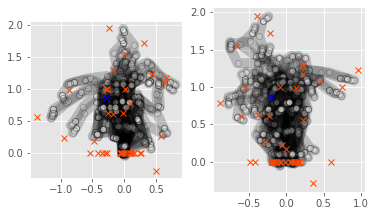

In [26]:
_batch_size = 20
feed_dict={batch_size: _batch_size, eps_var:1.}
feed_dict[batch_target] = get_target_new_batch(_batch_size=int(_batch_size/N_net))

_links, _com , _b_targets = sess.run(
[samples_links, samples_com, batch_target], feed_dict
)

fig, ax = plt.subplots(ncols=2)

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')

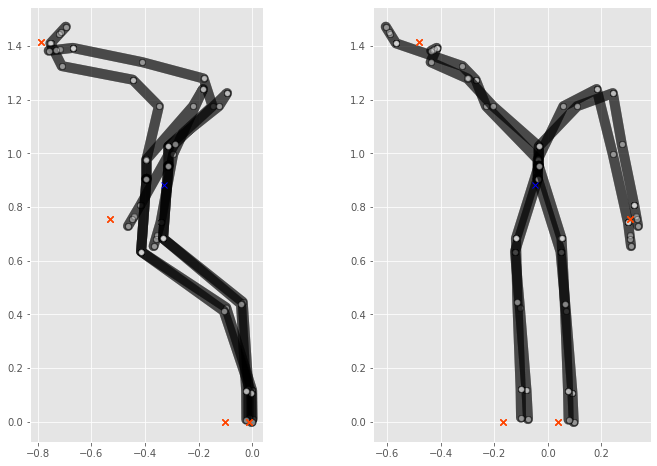

In [27]:
from_dataset = 0
n = 10

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.3] * 3 + [0.3]*3 +  [0.1]*2 + [0.] + [0.1] * 2 + [0.]  )  # variance

if from_dataset: 
    _targets = get_target_batch(cut=10000, _batch_size=1) * np.ones((int(n/N_net), 1))
else:
    _targets = np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (1, )) * np.ones((int(n/N_net), 1))

feed_dict={batch_size: n, batch_target: _targets, eps_var:.01}


_links, _com , _b_targets, _samples_q = sess.run(
    [samples_links, samples_com, batch_target, samples_q], 
    feed_dict)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    #ax[i].set_xlim([-.7, .7])
    #x[i].set_ylim([-0.1, 1.2])
#plt.savefig('data/talos_config.png')
plt.show()  


## Part 2: Use it for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [28]:
import pybullet as p
import pybullet_data
from utils import *
from scipy.optimize import fmin_bfgs
from costs import *
from robot import *
from scipy.optimize import fmin_bfgs
from functools import partial

In [29]:
physics_client_id = p.connect(p.GUI)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [30]:
p.resetSimulation()

#### Load in pybullet

In [31]:
#load robot
robot_urdf = DATA_PATH + '/urdf/talos_reduced.urdf';
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)

#load plane
plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

#set default visualization function
set_q_std = partial(set_q,robot_id, pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

#### Define frame indices

In [32]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1] for i in range(dof)]

In [33]:
pb_lh_frame_id = pb_frame_names.index(b'gripper_left_joint')
pb_rh_frame_id = pb_frame_names.index(b'gripper_right_joint')
pb_lf_frame_id = pb_frame_names.index(b'leg_left_sole_fix_joint')
pb_rf_frame_id = pb_frame_names.index(b'leg_right_sole_fix_joint')

#### Load from pinocchio

In [34]:
robot_urdf = DATA_PATH + '/urdf/talos_reduced.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])

pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('gripper_left_joint')
rh_frame_id = rmodel.getFrameId('gripper_right_joint')
lf_frame_id = rmodel.getFrameId('leg_left_sole_fix_joint')
rf_frame_id = rmodel.getFrameId('leg_right_sole_fix_joint')

#### Define target poses

In [35]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

In [36]:
class TalosIKSolver():
    def __init__(self, cost):
        self.cost = cost

    def __call__(self, xk):
        if False not in self.cost.feasibles:
            # print('Stop at iteration!' + str(self.cost.nfev))
            raise Exception

    def project(self, q, target_pose, ftol=1e-12, gtol=1e-12, disp=0, maxiter=300):
        # update the variables
        self.cost.reset_iter()
        self.cost.costs['posture'].cost.desired_posture = q.copy()

        self.cost.costs['rh_pose'].cost.desired_pose[:3] = target_pose[0:3]
        self.cost.costs['lh_pose'].cost.desired_pose[:3] = target_pose[3:6]
        self.cost.costs['rf_pose'].cost.desired_pose[:3] = target_pose[6:9]
        self.cost.costs['lf_pose'].cost.desired_pose[:3] = target_pose[9:]
        
        status = False
        try:
            res = minimize(self.cost.calc, q, method='l-bfgs-b', jac=self.cost.calcDiff, callback=self.__call__,
                           options={'ftol': ftol, 'gtol': gtol, 'disp': disp, 'maxiter': maxiter})
        except:
            # Optimization manage to get solution
            status = True
        res = {'stat': status, 'q': self.cost.qs[-1], 'qs': self.cost.qs, 'nfev': self.cost.nfev,
               'feval': self.cost.feval}
        return res

### Define IK solver

In [37]:
rh_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, sel_vector=np.array([1,1,1,0,0,0]))
lh_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_lh_ref,lh_frame_id, sel_vector=np.array([1,1,1,0,0,0]))
lf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_lf_ref,lf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
rf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rf_ref,rf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
bound_cost = CostBound(robot_joint_limits)
posture_cost = CostPosture(rmodel, rdata, q0Complete)
com_bounds = np.array([[-0.1,-0.1,0.6],[0.1, 0.1, 1.1]])
cost_com_bounds = CostCOMBounds(rmodel, rdata, com_bounds)

cost_sum2 = CostSum()
cost_sum2.addCost(rh_cost, 20., 'rh_pose', 1e-3)
cost_sum2.addCost(lh_cost, 20., 'lh_pose', 1e-3)
cost_sum2.addCost(lf_cost, 20., 'lf_pose', 1e-5)
cost_sum2.addCost(rf_cost, 20.,'rf_pose', 1e-5)
cost_sum2.addCost(bound_cost, 10., 'com_limit', 1e-4)
cost_sum2.addCost(cost_com_bounds, 10., 'joint_limit', 1e-4)
cost_sum2.addCost(posture_cost, .01, 'posture', 1e3)

robot_ik_solver = TalosIKSolver(cost_sum2)

### Try IK Solver

In [38]:
#define standard sampler
base_sampler = sampler(com_bounds.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler)

In [39]:
target_pose = np.concatenate([pose_rh_ref[:3], pose_lh_ref[:3], pose_rf_ref[:3], pose_lf_ref[:3]])

In [40]:
np.set_printoptions(precision=4, suppress=True)

In [41]:
target_pose = np.array([ 0.2139, -0.4009,  0.7583,  0.3   ,  0.2   ,  0.4   , 0.1088,
       -0.0852, -0.    , -0.0088,  0.0848, -0.    ])

In [42]:
q = rob_sampler.sample()[0]
set_q_std(q)
input()
res = robot_ik_solver.project(q, target_pose, disp=1)
set_q_std(res['q'])
print(res['stat'])

True


#### Using GAN sampler

In [43]:
class GANSampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
    
    def sample(self,N = 1, _poses = None, var = 1., idx_input = None):
        if _poses is None:
            _poses = self.target_sampler.sample(N)
        self.poses = _poses
        _foot_poses = np.tile(np.concatenate([pose_rf_ref[:3], pose_lf_ref[:3]]), (N,1))
        _targets = np.hstack([_poses, _foot_poses])
        feed_dict={batch_size: N*N_net, batch_target: _targets, eps_var:var}
        feed_dict[batch_foot_ori] = _batch_foot_ori

        _samples_q = sess.run([samples_q],feed_dict)
        _samples_q = _samples_q[0]
        print(_samples_q.shape)
        qnew = []
        for i in range(N):
            #samples from N_net networks
            if idx_input is None:
                idx = np.random.randint(N_net)
            else:
                idx = idx_input
            q = _samples_q[idx*N + i]
            qnew += [get_pb_config(q)]
        return np.array(qnew)

In [ ]:
gan_sampler = GANSampler(target_sampler)

#### Try GAN sampler


In [ ]:
#q = gan_sampler.sample(_poses = np.array([[-0.2, -0.3, 1.]]))[0]
q = gan_sampler.sample()[0]
set_q_std(q)

#### Try random

In [ ]:
target_samples = target_sampler.sample(N = 10)
samples = gan_sampler.sample(_poses = target_samples, N=len(target_samples), var=0.1)
for i in range(10):
    set_q_std(samples[i])
    p.resetBasePositionAndOrientation(ball_id, target_samples[i], (0,0,0,1))
    input()

In [ ]:
def make_animation(qs,targets, filename='data/videos.mp4'):
    for i,q in enumerate(qs):
        p.resetBasePositionAndOrientation(ball_id, targets[i], (0,0,0,1))
        set_q_std(q)
        save_screenshot(200, 200, 800, 1000, 'data/temp'+str(i)+'.png', to_show=False)
    #make into videos
    os.system('ffmpeg -r 25 -start_number 0 -i data/temp%d.png -c:v libx264 -r 30 -pix_fmt yuv420p ' + filename)
    os.system('rm data/temp*')

In [ ]:
make_animation(qs, ps)

### Compare the IK solver

In [ ]:
targets = data_target[:2000,:3]
samples = gan_sampler.sample(N=2000, _poses=targets, var = 0.1)

In [ ]:
N = 10
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose[:3] = targets[i]
        res = robot_ik_solver.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [ ]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

***

## Generate dataset

In [ ]:
_,_,left_box_id = create_primitives(p.GEOM_BOX, halfExtents=[0.25/2, 0.13/2, 0.01/2])

In [ ]:
p.resetBasePositionAndOrientation(left_box_id, (pos_lf), (0,0,0,1))

In [ ]:
_,_,right_box_id = create_primitives(p.GEOM_BOX, halfExtents=[0.25/2, 0.13/2, 0.01/2])

In [ ]:
p.resetBasePositionAndOrientation(right_box_id, (pos_rf), (0,0,0,1))

In [ ]:
_,_,right_ball_id = create_primitives(radius=0.1)
_,_,left_ball_id = create_primitives(radius=0.1)

In [ ]:
for target in targets:
    q = rob_sampler.sample()[0]
    res = robot_ik_solver.project(q, target)
    p.resetBasePositionAndOrientation(right_ball_id, (target[:3]), (0,0,0,1))
    p.resetBasePositionAndOrientation(left_ball_id, (target[3:6]), (0,0,0,1))
    p.resetBasePositionAndOrientation(right_box_id, (target[6:9]), (0,0,0,1))
    p.resetBasePositionAndOrientation(left_box_id, (target[9:]), (0,0,0,1))
    set_q_std(res['q'])
    print(res['stat'])
    input()

In [ ]:
targets = get_target_new_batch(_batch_size=30000)

In [ ]:
data = []
threshold = 0.05
for i in range(15000):
    print('Iteration : ' + str(i))
    q = rob_sampler.sample()[0]
    ress = robot_ik_solver.project(q, targets[i])
    if ress['stat']:
        data += [ress['q']]
        
    if i%100 == 0:
        clear_output()
        
data = np.array(data)

data_tf = []
for d in data:
    data_tf += [get_tf_config(d)]
data_tf = np.array(data_tf)

In [ ]:
np.save('data_two_feet_moved_manual.npy',data_tf)
#data = np.load('data_two_feet_manual.npy')